In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature columns
feature_cols = [
    "year",
    "membership_year",
    "is_household",
    "vehicle_count",
    "vehicle_age_mean",
    "beløp",
    "gave_feedback",
    "mean_feedback",
    "age",
    "gender",
    "sentralitetsindex",
]

# Load the examples
train_examples = torch.load("all/train_examples.pt")
val_examples = torch.load("all/val_examples.pt")

In [3]:
# 4. Dataset & DataLoader
class ChurnDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        seq, length, label = self.examples[idx]
        return seq, length, label


def collate_fn(batch):
    seqs, lengths, labels = zip(*batch)
    # pad to the max seq‐len in the batch
    seqs_padded = pad_sequence(seqs, batch_first=True)  # [B, T, F]
    lengths = torch.tensor(lengths, dtype=torch.long)  # [B]
    labels = torch.tensor(labels, dtype=torch.long)  # [B]
    # build an attention mask: True == padding
    max_len = seqs_padded.size(1)
    # shape [B, T]: for each example, positions >= length are padding
    attn_mask = torch.arange(max_len, device=lengths.device).unsqueeze(0).expand(
        len(lengths), -1
    ) >= lengths.unsqueeze(1)
    return (
        seqs_padded.to(device),
        lengths.to(device),
        attn_mask.to(device),
        labels.to(device),
    )


train_ds = ChurnDataset(train_examples)
val_ds = ChurnDataset(val_examples)
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

In [4]:
# 5. Model
torch.manual_seed(42)


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (h_n, c_n) = self.lstm(packed)
        out = self.fc(h_n[-1])
        return out


# Instantiate model
input_size = len(feature_cols)
hidden_size = 64
num_layers = 2
num_classes = 3
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import wandb

num_epochs = 50

wandb.init(project="churn", name="lstm")


# 6. Training & Evaluation
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Train")
    for seqs, lengths, attn_mask, labels in loop:
        optimizer.zero_grad()
        outputs = model(seqs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Val")
    with torch.no_grad():
        for seqs, lengths, attn_mask, labels in loop:
            outputs = model(seqs, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


# Run training
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)

    print(
        f"Epoch {epoch:>2d}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )

    # Log to wandb
    wandb.log(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        }
    )

wandb.finish()

wandb: Currently logged in as: junta to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Val: 100%|██████████| 147/147 [00:05<00:00, 25.38it/s, acc=0.545, loss=0.86] 


Epoch  1: train_loss=0.9429, train_acc=0.5271 | val_loss=0.9150, val_acc=0.5445


Val: 100%|██████████| 147/147 [00:04<00:00, 32.33it/s, acc=0.545, loss=0.849]


Epoch  2: train_loss=0.9065, train_acc=0.5454 | val_loss=0.9058, val_acc=0.5446


Val: 100%|██████████| 147/147 [00:05<00:00, 26.56it/s, acc=0.547, loss=0.837]


Epoch  3: train_loss=0.8984, train_acc=0.5465 | val_loss=0.8985, val_acc=0.5467


Val: 100%|██████████| 147/147 [00:04<00:00, 33.34it/s, acc=0.55, loss=0.835] 


Epoch  4: train_loss=0.8949, train_acc=0.5482 | val_loss=0.8941, val_acc=0.5502


Val: 100%|██████████| 147/147 [00:05<00:00, 26.07it/s, acc=0.549, loss=0.84] 


Epoch  5: train_loss=0.8931, train_acc=0.5484 | val_loss=0.8952, val_acc=0.5485


Val: 100%|██████████| 147/147 [00:02<00:00, 60.74it/s, acc=0.547, loss=0.833]


Epoch  6: train_loss=0.8914, train_acc=0.5477 | val_loss=0.8946, val_acc=0.5474


Val: 100%|██████████| 147/147 [00:02<00:00, 60.06it/s, acc=0.55, loss=0.83]  


Epoch  7: train_loss=0.8899, train_acc=0.5493 | val_loss=0.8904, val_acc=0.5502


Val: 100%|██████████| 147/147 [00:02<00:00, 60.90it/s, acc=0.551, loss=0.83] 


Epoch  8: train_loss=0.8887, train_acc=0.5499 | val_loss=0.8892, val_acc=0.5513


Val: 100%|██████████| 147/147 [00:03<00:00, 42.20it/s, acc=0.552, loss=0.833]


Epoch  9: train_loss=0.8875, train_acc=0.5503 | val_loss=0.8891, val_acc=0.5518


Val: 100%|██████████| 147/147 [00:03<00:00, 43.82it/s, acc=0.549, loss=0.829]


Epoch 10: train_loss=0.8859, train_acc=0.5510 | val_loss=0.8876, val_acc=0.5492


Val: 100%|██████████| 147/147 [00:02<00:00, 60.28it/s, acc=0.553, loss=0.827]


Epoch 11: train_loss=0.8845, train_acc=0.5519 | val_loss=0.8891, val_acc=0.5526


Val: 100%|██████████| 147/147 [00:02<00:00, 59.85it/s, acc=0.551, loss=0.833]


Epoch 12: train_loss=0.8830, train_acc=0.5526 | val_loss=0.8843, val_acc=0.5506


Val: 100%|██████████| 147/147 [00:03<00:00, 46.03it/s, acc=0.554, loss=0.834]


Epoch 13: train_loss=0.8813, train_acc=0.5536 | val_loss=0.8841, val_acc=0.5544


Val: 100%|██████████| 147/147 [00:03<00:00, 47.79it/s, acc=0.554, loss=0.836]


Epoch 14: train_loss=0.8800, train_acc=0.5538 | val_loss=0.8817, val_acc=0.5541


Val: 100%|██████████| 147/147 [00:02<00:00, 61.49it/s, acc=0.554, loss=0.828]


Epoch 15: train_loss=0.8779, train_acc=0.5546 | val_loss=0.8821, val_acc=0.5541


Val: 100%|██████████| 147/147 [00:02<00:00, 60.38it/s, acc=0.556, loss=0.833]


Epoch 16: train_loss=0.8767, train_acc=0.5555 | val_loss=0.8824, val_acc=0.5555


Val: 100%|██████████| 147/147 [00:02<00:00, 61.48it/s, acc=0.555, loss=0.823]


Epoch 17: train_loss=0.8753, train_acc=0.5572 | val_loss=0.8806, val_acc=0.5548


Val: 100%|██████████| 147/147 [00:02<00:00, 64.25it/s, acc=0.557, loss=0.829]


Epoch 18: train_loss=0.8735, train_acc=0.5578 | val_loss=0.8816, val_acc=0.5566


Val: 100%|██████████| 147/147 [00:02<00:00, 61.91it/s, acc=0.556, loss=0.827]


Epoch 19: train_loss=0.8725, train_acc=0.5591 | val_loss=0.8777, val_acc=0.5564


Val: 100%|██████████| 147/147 [00:02<00:00, 59.59it/s, acc=0.557, loss=0.826]


Epoch 20: train_loss=0.8715, train_acc=0.5591 | val_loss=0.8777, val_acc=0.5568


Val: 100%|██████████| 147/147 [00:03<00:00, 45.07it/s, acc=0.559, loss=0.827]


Epoch 21: train_loss=0.8706, train_acc=0.5599 | val_loss=0.8752, val_acc=0.5587


Val: 100%|██████████| 147/147 [00:03<00:00, 47.83it/s, acc=0.557, loss=0.824]


Epoch 22: train_loss=0.8695, train_acc=0.5603 | val_loss=0.8758, val_acc=0.5570


Val: 100%|██████████| 147/147 [00:02<00:00, 60.04it/s, acc=0.558, loss=0.821]


Epoch 23: train_loss=0.8690, train_acc=0.5605 | val_loss=0.8752, val_acc=0.5578


Val: 100%|██████████| 147/147 [00:02<00:00, 61.24it/s, acc=0.556, loss=0.834]


Epoch 24: train_loss=0.8678, train_acc=0.5616 | val_loss=0.8773, val_acc=0.5559


Val: 100%|██████████| 147/147 [00:02<00:00, 59.72it/s, acc=0.556, loss=0.819]


Epoch 25: train_loss=0.8672, train_acc=0.5622 | val_loss=0.8763, val_acc=0.5557


Val: 100%|██████████| 147/147 [00:02<00:00, 61.73it/s, acc=0.558, loss=0.828]


Epoch 26: train_loss=0.8665, train_acc=0.5622 | val_loss=0.8750, val_acc=0.5582


Val: 100%|██████████| 147/147 [00:02<00:00, 62.00it/s, acc=0.557, loss=0.818]


Epoch 27: train_loss=0.8658, train_acc=0.5628 | val_loss=0.8746, val_acc=0.5570


Val: 100%|██████████| 147/147 [00:02<00:00, 62.46it/s, acc=0.558, loss=0.832]


Epoch 28: train_loss=0.8651, train_acc=0.5630 | val_loss=0.8746, val_acc=0.5582


Val: 100%|██████████| 147/147 [00:02<00:00, 61.61it/s, acc=0.555, loss=0.828]


Epoch 29: train_loss=0.8645, train_acc=0.5635 | val_loss=0.8742, val_acc=0.5553


Val: 100%|██████████| 147/147 [00:02<00:00, 62.19it/s, acc=0.559, loss=0.817]


Epoch 30: train_loss=0.8637, train_acc=0.5639 | val_loss=0.8730, val_acc=0.5589


Val: 100%|██████████| 147/147 [00:02<00:00, 69.42it/s, acc=0.557, loss=0.817]


Epoch 31: train_loss=0.8632, train_acc=0.5641 | val_loss=0.8742, val_acc=0.5569


Val: 100%|██████████| 147/147 [00:02<00:00, 61.37it/s, acc=0.557, loss=0.824]


Epoch 32: train_loss=0.8625, train_acc=0.5638 | val_loss=0.8737, val_acc=0.5572


Val: 100%|██████████| 147/147 [00:02<00:00, 61.26it/s, acc=0.558, loss=0.823]


Epoch 33: train_loss=0.8617, train_acc=0.5647 | val_loss=0.8743, val_acc=0.5576


Val: 100%|██████████| 147/147 [00:02<00:00, 61.35it/s, acc=0.558, loss=0.817]


Epoch 34: train_loss=0.8610, train_acc=0.5653 | val_loss=0.8736, val_acc=0.5576


Val: 100%|██████████| 147/147 [00:02<00:00, 73.47it/s, acc=0.556, loss=0.823]


Epoch 35: train_loss=0.8606, train_acc=0.5652 | val_loss=0.8747, val_acc=0.5564


Val: 100%|██████████| 147/147 [00:02<00:00, 61.91it/s, acc=0.558, loss=0.822]


Epoch 36: train_loss=0.8601, train_acc=0.5657 | val_loss=0.8735, val_acc=0.5581


Val: 100%|██████████| 147/147 [00:02<00:00, 67.59it/s, acc=0.558, loss=0.814]


Epoch 37: train_loss=0.8592, train_acc=0.5670 | val_loss=0.8748, val_acc=0.5575


Val: 100%|██████████| 147/147 [00:02<00:00, 61.13it/s, acc=0.557, loss=0.819]


Epoch 38: train_loss=0.8588, train_acc=0.5670 | val_loss=0.8735, val_acc=0.5568


Val: 100%|██████████| 147/147 [00:02<00:00, 60.44it/s, acc=0.556, loss=0.826]


Epoch 39: train_loss=0.8581, train_acc=0.5678 | val_loss=0.8743, val_acc=0.5558


Val: 100%|██████████| 147/147 [00:02<00:00, 60.96it/s, acc=0.558, loss=0.817]


Epoch 40: train_loss=0.8574, train_acc=0.5673 | val_loss=0.8747, val_acc=0.5577


Val: 100%|██████████| 147/147 [00:02<00:00, 61.15it/s, acc=0.556, loss=0.826]


Epoch 41: train_loss=0.8569, train_acc=0.5685 | val_loss=0.8746, val_acc=0.5562


Val: 100%|██████████| 147/147 [00:02<00:00, 61.70it/s, acc=0.557, loss=0.825]


Epoch 42: train_loss=0.8559, train_acc=0.5689 | val_loss=0.8764, val_acc=0.5568


Val: 100%|██████████| 147/147 [00:02<00:00, 61.04it/s, acc=0.555, loss=0.83] 


Epoch 43: train_loss=0.8554, train_acc=0.5698 | val_loss=0.8764, val_acc=0.5547


Val: 100%|██████████| 147/147 [00:02<00:00, 62.39it/s, acc=0.557, loss=0.816]


Epoch 44: train_loss=0.8546, train_acc=0.5700 | val_loss=0.8759, val_acc=0.5573


Val: 100%|██████████| 147/147 [00:02<00:00, 60.24it/s, acc=0.555, loss=0.824]


Epoch 45: train_loss=0.8541, train_acc=0.5704 | val_loss=0.8769, val_acc=0.5554


Val: 100%|██████████| 147/147 [00:03<00:00, 46.68it/s, acc=0.557, loss=0.828]


Epoch 46: train_loss=0.8534, train_acc=0.5712 | val_loss=0.8767, val_acc=0.5566


Val: 100%|██████████| 147/147 [00:02<00:00, 52.44it/s, acc=0.555, loss=0.827]


Epoch 47: train_loss=0.8528, train_acc=0.5712 | val_loss=0.8769, val_acc=0.5550


Val: 100%|██████████| 147/147 [00:02<00:00, 60.37it/s, acc=0.556, loss=0.819]


Epoch 48: train_loss=0.8519, train_acc=0.5723 | val_loss=0.8795, val_acc=0.5557


Val: 100%|██████████| 147/147 [00:02<00:00, 60.78it/s, acc=0.555, loss=0.829]


Epoch 49: train_loss=0.8512, train_acc=0.5732 | val_loss=0.8789, val_acc=0.5548


Val: 100%|██████████| 147/147 [00:03<00:00, 47.69it/s, acc=0.553, loss=0.827]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 50: train_loss=0.8506, train_acc=0.5731 | val_loss=0.8792, val_acc=0.5534


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
train_loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▂▄▃▄▄▅▃▅▆▆▆▆▆▇▇██▇█▇█▆▇▇▇▇█▇▇█▇▇▆▆▇▆▇▅
val_loss,█▆▅▅▅▄▄▄▃▄▃▂▃▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
epoch,50
train_accuracy,0.57308
train_loss,0.8506
val_accuracy,0.55335
val_loss,0.87917


ROC AUC Score (OvR): 0.7415

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.59      0.55     21127
           1       0.63      0.65      0.64     34706
           2       0.44      0.34      0.38     19394

    accuracy                           0.55     75227
   macro avg       0.53      0.53      0.52     75227
weighted avg       0.55      0.55      0.55     75227



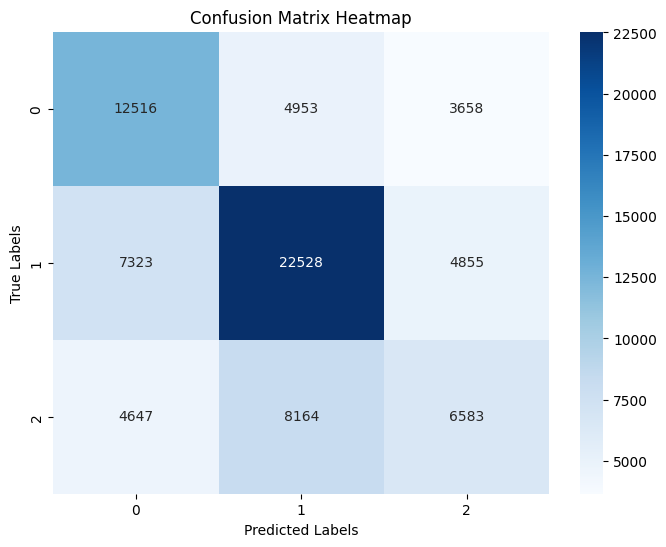

In [6]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Collect all true labels and predicted probabilities
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for seqs, lengths, attn_mask, labels in tqdm(
        val_loader, desc="Collecting predictions"
    ):
        outputs = model(seqs, lengths)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

# 2. ROC AUC Score (one-vs-rest for multiclass)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

# 3. Classification Report
report = classification_report(all_labels, all_preds)
print("\nClassification Report:\n", report)

# 4. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()